# 환경/로드

In [1]:
# --- 기본 imports ---
import os
import numpy as np
import pandas as pd

# 시각화 (노트북용)
import matplotlib.pyplot as plt

# (선택) plotly로도 보고 싶으면
import plotly.express as px


pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("Ready")


Ready


In [11]:
import os
import json
import pandas as pd
import streamlit as st


@st.cache_data
def load_csv(path: str):
    """CSV 전체 로드 (샘플링 없음)"""
    return pd.read_csv(path)


@st.cache_data
def load_tsv(path: str):
    """TSV 파일 로딩"""
    return pd.read_csv(path, sep="\t")


@st.cache_data
def load_json(path: str):
    """JSON 파일 로딩"""
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None


def load_all_data(base_path: str):
    """
    base_path 아래 데이터셋을 모두 로드해서 dict로 반환.
    모든 데이터 FULL LOAD (샘플링 없음)
    """
    data = {}

    # ratings (FULL LOAD)
    ratings_path = os.path.join(base_path, "train_ratings.csv")
    data["ratings"] = load_csv(ratings_path)

    # tsv들
    data["titles"] = load_tsv(os.path.join(base_path, "titles.tsv"))
    data["years"] = load_tsv(os.path.join(base_path, "years.tsv"))
    data["genres"] = load_tsv(os.path.join(base_path, "genres.tsv"))
    data["directors"] = load_tsv(os.path.join(base_path, "directors.tsv"))
    data["writers"] = load_tsv(os.path.join(base_path, "writers.tsv"))

    # JSON mapping
    json_path = os.path.join(base_path, "Ml_item2attributes.json")
    data["item2attributes"] = load_json(json_path)

    return data

    


2025-12-22 12:45:46.604 No runtime found, using MemoryCacheStorageManager
2025-12-22 12:45:46.606 No runtime found, using MemoryCacheStorageManager
2025-12-22 12:45:46.607 No runtime found, using MemoryCacheStorageManager


In [12]:
# --- 데이터 경로 설정 ---
# 방법1: 환경변수로 받기 (추천)
# DATA_PATH = os.environ.get("DATA_PATH", None)

# 방법2: 직접 넣기
DATA_PATH = "/data/ephemeral/home/data/raw/train"

# assert DATA_PATH is not None, "DATA_PATH를 환경변수로 넣거나 위에서 직접 지정해줘!"

data = load_all_data(DATA_PATH)
ratings = data["ratings"].copy()

ratings["datetime"] = pd.to_datetime(ratings["time"], unit="s")
ratings.head(), ratings.shape


(   user  item        time            datetime
 0    11  4643  1230782529 2009-01-01 04:02:09
 1    11   170  1230782534 2009-01-01 04:02:14
 2    11   531  1230782539 2009-01-01 04:02:19
 3    11   616  1230782542 2009-01-01 04:02:22
 4    11  2140  1230782563 2009-01-01 04:02:43,
 (5154471, 4))

# 1) 기본 QA (데이터 이상치/형 체크)

In [13]:
display(ratings.describe(include="all"))
print("null counts:\n", ratings.isna().sum())
print("dtypes:\n", ratings.dtypes)

# 유니크 수
print("n_users:", ratings["user"].nunique())
print("n_items:", ratings["item"].nunique())
print("n_rows:", len(ratings))


,user,item,time,datetime
count,5.154471e+06,5.154471e+06,5.154471e+06,5154471
mean,6.875153e+04,1.716849e+04,1.248017e+09,2009-07-19 15:17:48.336951296
min,1.100000e+01,1.000000e+00,1.113221e+09,2005-04-11 11:56:25
25%,3.419900e+04,1.304000e+03,1.170355e+09,2007-02-01 18:32:53
50%,6.860500e+04,3.897000e+03,1.234651e+09,2009-02-14 22:39:14
75%,1.032010e+05,2.671200e+04,1.318284e+09,2011-10-10 22:01:38.500000
max,1.384930e+05,1.191450e+05,1.427781e+09,2015-03-31 05:50:52
std,3.993460e+04,2.633563e+04,8.968302e+07,NaN


null counts:
 user        0
item        0
time        0
datetime    0
dtype: int64
dtypes:
 user                 int64
item                 int64
time                 int64
datetime    datetime64[ns]
dtype: object
n_users: 31360
n_items: 6807
n_rows: 5154471


In [14]:
# time 범위
print("time min:", ratings["datetime"].min())
print("time max:", ratings["datetime"].max())
print("time span days:", (ratings["datetime"].max() - ratings["datetime"].min()).days)


time min: 2005-04-11 11:56:25
time max: 2015-03-31 05:50:52
time span days: 3640


# 2) Long-tail 확인: user/item interaction 분포

## (A) 분포 요약 + 핵심 통계(퍼센타일)

In [15]:
user_counts = ratings.groupby("user")["item"].count().rename("interaction_count")
item_counts = ratings.groupby("item")["user"].count().rename("interaction_count")

def dist_summary(s: pd.Series, name: str):
    q = s.quantile([0.5, 0.75, 0.9, 0.95, 0.99])
    out = pd.DataFrame({
        "name":[name],
        "n":[s.shape[0]],
        "min":[s.min()],
        "p50":[q.loc[0.5]],
        "p75":[q.loc[0.75]],
        "p90":[q.loc[0.9]],
        "p95":[q.loc[0.95]],
        "p99":[q.loc[0.99]],
        "max":[s.max()],
        "mean":[s.mean()],
    })
    return out

summary_df = pd.concat([
    dist_summary(user_counts, "user_counts"),
    dist_summary(item_counts, "item_counts")
], ignore_index=True)

summary_df


,name,n,min,p50,p75,p90,p95,p99,max,mean
0,user_counts,31360,16,114.0,200.0,335.0,450.05,758.00,2912,164.364509
1,item_counts,6807,27,197.0,610.5,1852.8,3312.10,9285.04,19699,757.230939


## (B) 히스토그램 (노트북에서는 matplotlib로 빠르게)

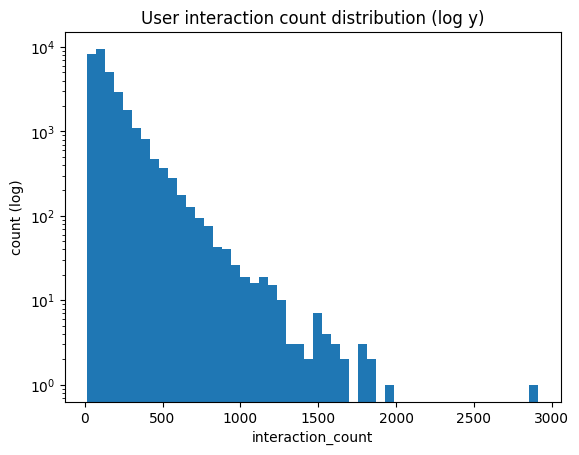

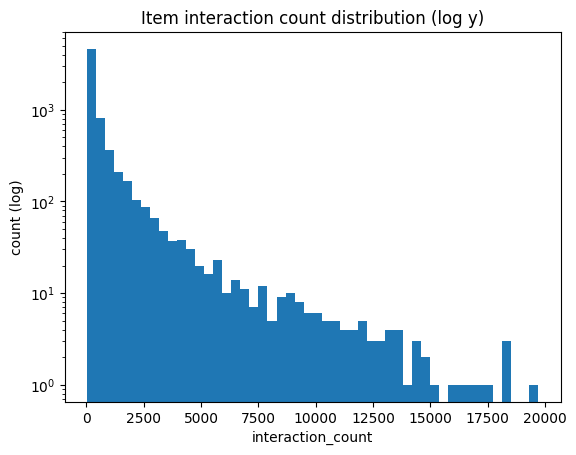

In [16]:
plt.figure()
plt.hist(user_counts, bins=50)
plt.yscale("log")
plt.title("User interaction count distribution (log y)")
plt.xlabel("interaction_count")
plt.ylabel("count (log)")
plt.show()

plt.figure()
plt.hist(item_counts, bins=50)
plt.yscale("log")
plt.title("Item interaction count distribution (log y)")
plt.xlabel("interaction_count")
plt.ylabel("count (log)")
plt.show()


## 3) Heavy user/item 영향: Top N%가 interaction 몇 % 먹는지
- 결과 해석 : 상위 10%의 user는 전체 interaction의 약 31%를 차지하는 반면, 상위 10%의 item은 약 61%를 차지하여 item 기준으로 훨씬 강한 집중 현상이 관찰되었다. 이는 본 데이터셋이 user 중심의 독점 구조라기보다는 소수의 인기 item에 상호작용이 집중되는 전형적인 long-tail 구조임을 의미하며, user-based CF보다 item-based CF가 더 안정적인 추천 성능을 보일 가능성을 시사한다.
- 본 데이터는 **파레토 법칙**이 강하게 작동하는 구조로, 소수의 인기 아이템이 전체 interaction의 대부분을 차지하는 전형적인 long-tail 분포를 보인다

In [20]:
def heavy_share(counts: pd.Series, top_percent: float):
    sorted_counts = counts.sort_values(ascending=False)
    k = max(1, int(len(sorted_counts) * (top_percent / 100.0)))
    share = sorted_counts.iloc[:k].sum() / sorted_counts.sum()
    return {
        "top_percent": top_percent,
        "k": k,
        "share": float(share),
        "top_k_sum": int(sorted_counts.iloc[:k].sum()),
        "total_sum": int(sorted_counts.sum())
    }

top_grid = [0.1, 0.5, 1, 2, 5, 10, 20]
rows = []
for p in top_grid:
    rows.append({"type":"user", **heavy_share(user_counts, p)})
    rows.append({"type":"item", **heavy_share(item_counts, p)})

heavy_df = pd.DataFrame(rows)
heavy_df["share_pct"] = heavy_df["share"] * 100
heavy_df


,type,top_percent,k,share,top_k_sum,total_sum,share_pct
0,user,0.1,31,0.009640,49691,5154471,0.964037
1,item,0.1,6,0.021163,109082,5154471,2.116260
2,user,0.5,156,0.035443,182691,5154471,3.544321
3,item,0.5,34,0.095016,489758,5154471,9.501615
4,user,1.0,313,0.060440,311537,5154471,6.044015
5,item,1.0,68,0.164150,846108,5154471,16.415031
6,user,2.0,627,0.101788,524662,5154471,10.178775
7,item,2.0,136,0.267056,1376531,5154471,26.705573
8,user,5.0,1568,0.197009,1015477,5154471,19.700897
9,item,5.0,340,0.447047,2304291,5154471,44.704704


In [21]:
# 표를 보기 좋게 피벗
pivot = heavy_df.pivot(index="top_percent", columns="type", values="share_pct")
pivot


type,item,user
top_percent,,
0.1,2.116260,0.964037
0.5,9.501615,3.544321
1.0,16.415031,6.044015
2.0,26.705573,10.178775
5.0,44.704704,19.700897
10.0,60.953685,31.393309
20.0,77.239837,48.081365


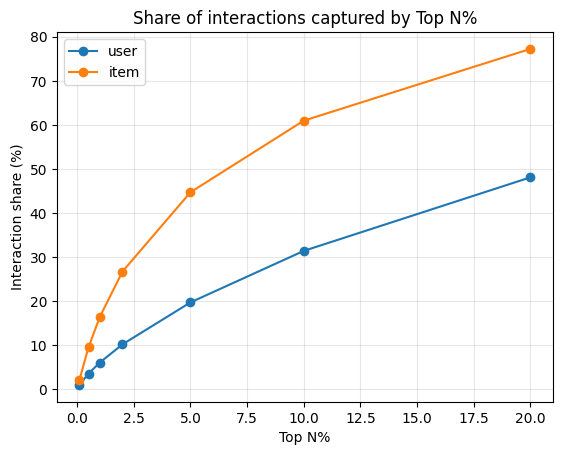

In [22]:
# 라인플롯(Top% 변화에 따라 점유율 변화) - Streamlit에 올리면 꽤 강력함
plt.figure()
plt.plot(pivot.index, pivot["user"], marker="o", label="user")
plt.plot(pivot.index, pivot["item"], marker="o", label="item")
plt.title("Share of interactions captured by Top N%")
plt.xlabel("Top N%")
plt.ylabel("Interaction share (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## (A) Cold user 비율 (interaction 1~k)

In [ ]:
def cold_user_ratio(user_counts: pd.Series, k: int):
    return (user_counts <= k).mean()

for k in [10, 50, 100, 300, 500]: # 16	114.0	200.0	335.0	450.05	758.00	2912
    print(f"cold users (<= {k} interactions): {cold_user_ratio(user_counts, k)*100:.2f}%")


cold users (<= 10 interactions): 0.00%
cold users (<= 50 interactions): 6.29%
cold users (<= 100 interactions): 43.48%
cold users (<= 300 interactions): 87.74%
cold users (<= 500 interactions): 96.21%


## (B) 유저별 “겹침” 가능성(같은 아이템을 본 사람이 얼마나 있냐)

user-based CF는 유저 간 공통 아이템(코레이팅) 없으면 유사도 계산이 무너짐.
빠른 근사로 “각 아이템의 유저 수 분포”를 보거나, 더 세게는 “랜덤 유저쌍 overlap” 샘플링을 봄.


Jaccard = |A ∩ B| / |A ∪ B|


Jaccard stats: [0.06643357 0.14112667 0.16855695 0.21680103] max: 0.3539518900343643


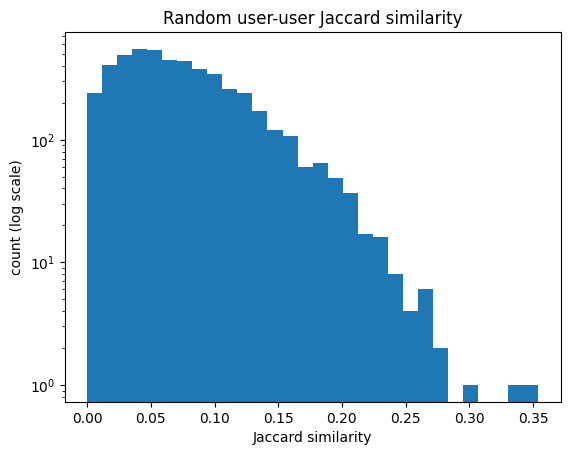

In [30]:
# (정규화 버전) 유저쌍 Jaccard Similarity 샘플링
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt

# 유저 → 본 item 집합
user_items = ratings.groupby("user")["item"].apply(set).to_dict()
users = list(user_items.keys())

sample_users = 2000
sample_pairs = 5000

# 샘플링할 유저들
sample_u = random.sample(users, min(sample_users, len(users)))
pairs = [(random.choice(sample_u), random.choice(sample_u)) for _ in range(sample_pairs)]

jaccards = []
for u, v in pairs:
    if u == v:
        continue
        
    A = user_items[u]
    B = user_items[v]
    
    inter = len(A & B)
    union = len(A | B)
    
    # Jaccard similarity
    if union > 0:
        j = inter / union
        jaccards.append(j)

jaccards = np.array(jaccards)

# 통계 출력
print("Jaccard stats:", 
      np.percentile(jaccards, [50, 90, 95, 99]),
      "max:", jaccards.max())

# 시각화
plt.figure()
plt.hist(jaccards, bins=30)
plt.yscale("log")
plt.title("Random user-user Jaccard similarity")
plt.xlabel("Jaccard similarity")
plt.ylabel("count (log scale)")
plt.show()


- ① 랜덤으로 두 유저를 뽑았을 때 평균 취향 유사도는 매우 낮아(중앙값 6.6%), 대부분의 유저는 서로 취향이 거의 안 겹친다.
- ② 상위 1~10% 유사한 쌍도 겹침이 14~21% 수준이라, 일부 소수 취향 집단만 부분적으로 비슷한 소비 패턴을 가진다.
- ③ 최대 유사도도 35% 정도여서 전체적으로 취향이 넓게 분산되어 있고, 특정 niche 그룹이 존재하는 구조다.

## 5) Heavy user timeline “진짜 의미 있나?” 체크 (노트북에서만 먼저)

✅ Streamlit 후보 여부 판단 기준(추천):

상위 heavy user들이 짧은 기간에 몰아보는지 / 장기간 꾸준한지 패턴이 뚜렷하면 올릴 가치 있음

그냥 점만 잔뜩 찍혀서 아무것도 안 보이면 Streamlit에서 빼고, “유저 time_std 분포” 쪽만 살리는 게 낫다.

In [31]:
# heavy user 상위 10
sorted_user = user_counts.sort_values(ascending=False)
top_user_list = sorted_user.index[:10].tolist()
top_user_list


[8405, 54465, 24219, 32514, 91349, 131904, 34576, 99754, 31122, 118754]

user: 8405 n: 2912


,user,item,time,datetime
315136,8405,1252,1160462492,2006-10-10 06:41:32
315137,8405,1278,1160462504,2006-10-10 06:41:44
315138,8405,2599,1160462620,2006-10-10 06:43:40
315139,8405,3408,1160462658,2006-10-10 06:44:18
315140,8405,2268,1160462698,2006-10-10 06:44:58


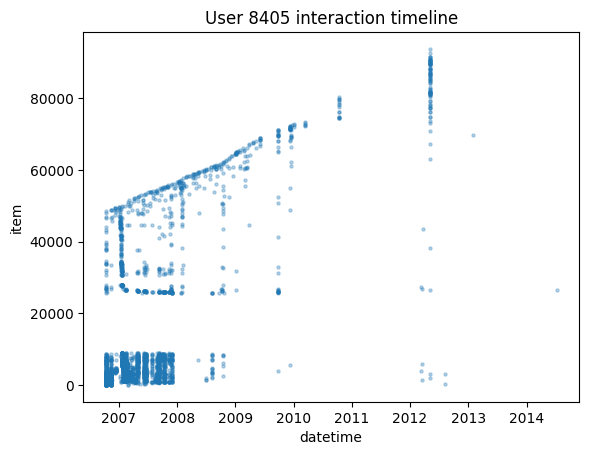

In [32]:
# 1명 찍어서 확인
u = top_user_list[0]
u_df = ratings[ratings["user"] == u].sort_values("datetime")

print("user:", u, "n:", len(u_df))
display(u_df.head())

# 간단 timeline (matplotlib)
plt.figure()
plt.scatter(u_df["datetime"], u_df["item"], s=5, alpha=0.3)
plt.title(f"User {u} interaction timeline")
plt.xlabel("datetime")
plt.ylabel("item")
plt.show()



# 6) 월별(연도 무관) seasonality — 실제로 패턴이 있나 확인

✅ Streamlit 후보:

그래프가 거의 평평하면 굳이 올릴 필요 없음

특정 월 튀면 “계절성” 근거가 생겨서 올릴 가치 상승

In [33]:
ratings["month"] = ratings["datetime"].dt.month
month_counts = ratings.groupby("month")["user"].count().reindex(range(1,13), fill_value=0)

month_counts


month
1     508889
2     417357
3     432249
4     406257
5     439160
6     414722
7     440935
8     386369
9     390955
10    442310
11    444009
12    431259
Name: user, dtype: int64

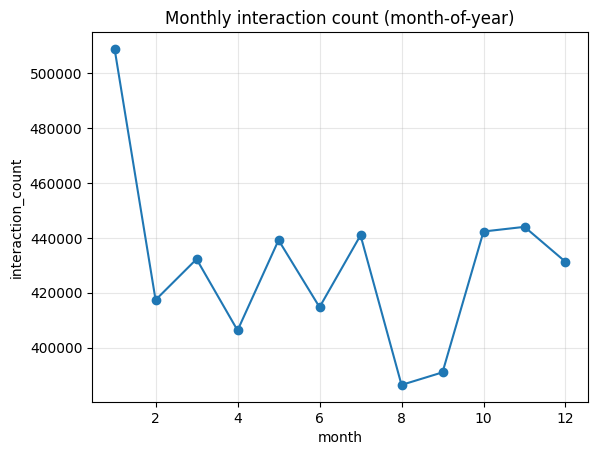

month mean: 429539.25 CV: 0.07416702363053683


In [34]:
plt.figure()
plt.plot(month_counts.index, month_counts.values, marker="o")
plt.title("Monthly interaction count (month-of-year)")
plt.xlabel("month")
plt.ylabel("interaction_count")
plt.grid(True, alpha=0.3)
plt.show()

# 변동성 숫자로도 확인 (패턴 약하면 Streamlit에서 빼도 됨)
mean = month_counts.mean()
cv = month_counts.std() / (mean + 1e-9)
print("month mean:", mean, "CV:", cv)


## 7) Timestamp std 분석 — Streamlit에 올릴지 판정
✅ Streamlit 후보:

std=0 비율 metric + std 분포 히스토그램은 꽤 유용함

다만 time_std 값 스케일이 너무 커서 해석이 애매하면 “일(day) 단위로 변환”해서 보여주는 게 더 깔끔함.

=== Time Std Distribution Summary (in days) ===
count    31360.000000
mean       129.325865
std        249.969670
min          0.000857
25%          0.016528
50%          3.330766
75%        129.070833
90%        476.849015
95%        739.053796
99%       1089.650462
max       1729.528881
Name: time_std_days, dtype: float64

std=0 (single-interaction users) ratio: 0.00%

=== Time Std Bucket Distribution (days) ===
time_std_days
0~1 day            13686
1~7 days            3318
7~30 days           2754
30~90 days          2597
90~180 days         2240
180~1729.5 days     6765
Name: count, dtype: int64


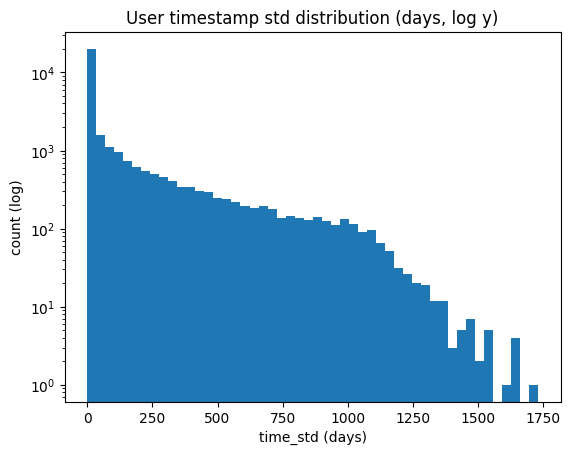

In [37]:
# --- 기존 계산 (time_std in seconds) ---
user_time_std = (
    ratings.groupby("user")["time"]
    .std()
    .fillna(0)
    .rename("time_std")
)

# --- 초 → 일(day) 단위 변환 ---
SEC_PER_DAY = 86400   # 24*60*60
user_time_std_days = (user_time_std / SEC_PER_DAY).rename("time_std_days")

# --- 기본 통계 요약 (일 단위) ---
stats = user_time_std_days.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("=== Time Std Distribution Summary (in days) ===")
print(stats)

# --- std = 0 비율 ---
zero_ratio = (user_time_std_days == 0).mean()
print(f"\nstd=0 (single-interaction users) ratio: {zero_ratio*100:.2f}%")

# --- 구간(bucket)별 분포 (일 단위 버킷) ---
bins = [0, 1, 7, 30, 90, 180, user_time_std_days.max()]  # 1일, 1주, 1달, 3달, 6달
labels = [
    "0~1 day",
    "1~7 days",
    "7~30 days",
    "30~90 days",
    "90~180 days",
    f"180~{user_time_std_days.max():.1f} days"
]

bucket_counts = pd.cut(user_time_std_days, bins=bins, labels=labels, include_lowest=True).value_counts()
print("\n=== Time Std Bucket Distribution (days) ===")
print(bucket_counts.sort_index())

# --- 그림 ---
plt.figure()
plt.hist(user_time_std_days, bins=50)
plt.yscale("log")
plt.title("User timestamp std distribution (days, log y)")
plt.xlabel("time_std (days)")
plt.ylabel("count (log)")
plt.show()


# 8) Streamlit에 “올릴 후보” 자동 체크 리스트 만들기 (의사결정용)

In [40]:
def interpret_candidates(c):
    lines = []

    # 1) long-tail 강도
    lines.append(f"- 아이템 인기도 상위 1%는 중간치(P50)보다 **{c['item_tail_ratio_p99_p50']:.2f}배** 더 많이 소비되어, 아이템 분포가 매우 long-tail 구조임을 보여준다.")
    lines.append(f"- 유저 활동량 상위 1%는 중간치(P50)보다 **{c['user_tail_ratio_p99_p50']:.2f}배** 더 많이 활동하여 heavy-user 비중이 존재하나, 아이템에 비해 쏠림은 덜하다.")

    # 2) cold user 비율
    lines.append(f"- 인터랙션 3회 이하의 초저활성(cold) 유저 비율은 **{c['cold_user_ratio_le3']*100:.2f}%**로, 단기 유저가 거의 없음을 의미한다.")

    # 3) top1 점유율
    lines.append(f"- 가장 활동적인 단일 유저는 전체 행동의 **{c['top1_user_share']*100:.2f}%**를 차지해 상위 유저 영향력이 존재한다.")
    lines.append(f"- 가장 인기 있는 단일 아이템은 전체 소비의 **{c['top1_item_share']*100:.2f}%**를 차지해 특정 인기 아이템 쏠림이 강하다.")

    # 4) 시즌성
    lines.append(f"- 월별 사용량 변동 계수(CV)는 **{c['month_cv']:.3f}**로 매우 낮아, 월별 시즌성은 거의 없는 안정적 이용 패턴을 보인다.")

    # 5) timestamp spread
    lines.append(f"- timestamp 표준편차가 0인 유저 비율은 **{c['time_std_zero_ratio']*100:.2f}%**, 즉 single-interaction 유저가 거의 없어 행동 기반 분석이 충분히 가능하다.")

    return "\n".join(lines)


# 결과 출력
print(interpret_candidates(candidates))


- 아이템 인기도 상위 1%는 중간치(P50)보다 **47.13배** 더 많이 소비되어, 아이템 분포가 매우 long-tail 구조임을 보여준다.
- 유저 활동량 상위 1%는 중간치(P50)보다 **6.65배** 더 많이 활동하여 heavy-user 비중이 존재하나, 아이템에 비해 쏠림은 덜하다.
- 인터랙션 3회 이하의 초저활성(cold) 유저 비율은 **0.00%**로, 단기 유저가 거의 없음을 의미한다.
- 가장 활동적인 단일 유저는 전체 행동의 **6.04%**를 차지해 상위 유저 영향력이 존재한다.
- 가장 인기 있는 단일 아이템은 전체 소비의 **16.42%**를 차지해 특정 인기 아이템 쏠림이 강하다.
- 월별 사용량 변동 계수(CV)는 **0.074**로 매우 낮아, 월별 시즌성은 거의 없는 안정적 이용 패턴을 보인다.
- timestamp 표준편차가 0인 유저 비율은 **0.00%**, 즉 single-interaction 유저가 거의 없어 행동 기반 분석이 충분히 가능하다.
